# Text Decoder Transformer - Natural Language Version

A decoder-only transformer for natural language text generation using Keras best practices. Adapted from the healthcare version with larger sequence lengths for text corpus training.

## Setup & Data Loading

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, losses, callbacks
import matplotlib.pyplot as plt
import requests
import re

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.9.2


In [10]:
# Download and prepare text corpus (Shakespeare as example)
def download_text_corpus(url="https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"):
    """Download a text corpus for training."""
    try:
        response = requests.get(url)
        text = response.text
    except:
        # Fallback to a simple text if download fails
        text = """To be or not to be, that is the question. Whether 'tis nobler in the mind to suffer 
        the slings and arrows of outrageous fortune, or to take arms against a sea of troubles and by opposing end them.
        The quick brown fox jumps over the lazy dog. A journey of a thousand miles begins with a single step.
        In the beginning was the Word, and the Word was with God, and the Word was God.
        All that glitters is not gold. Actions speak louder than words. Better late than never.
        """ * 100  # Repeat to create more text
    
    return text

# Download corpus
corpus_text = download_text_corpus()

# Clean and prepare text
def clean_text(text):
    """Clean and normalize text."""
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Keep basic punctuation
    text = re.sub(r'[^a-z0-9\s.,!?;:-]', '', text)
    return text.strip()

clean_corpus = clean_text(corpus_text)

# Create text sequences
def create_text_sequences(text, seq_length=50, overlap=25):
    """Create overlapping text sequences."""
    words = text.split()
    sequences = []
    
    for i in range(0, len(words) - seq_length, overlap):
        sequence = ' '.join(words[i:i + seq_length])
        if len(sequence.split()) == seq_length:
            sequences.append(sequence)
    
    return sequences

text_sequences = create_text_sequences(clean_corpus, seq_length=50, overlap=25)

print(f"Total text length: {len(clean_corpus)} characters")
print(f"Total sequences: {len(text_sequences)}")
print(f"Example sequence: {text_sequences[0][:100]}...")
print(f"Unique words (approx): {len(set(clean_corpus.split()))}")

Total text length: 1101961 characters
Total sequences: 8104
Example sequence: first citizen: before we proceed any further, hear me speak. all: speak, speak. first citizen: you a...
Unique words (approx): 23101


## Model Configuration

In [21]:
# Model hyperparameters - simplified to avoid overflow issues
CONFIG = {
    'vocab_size': 5000,         # Reduced vocabulary size
    'max_len': 32,              # Reduced sequence length
    'embed_dim': 128,           # Smaller embeddings
    'num_heads': 4,             # Fewer attention heads
    'ff_dim': 256,              # Smaller feed-forward dimension
    'num_layers': 3,            # Fewer layers
    'dropout_rate': 0.1,        # Keep regularization
    'batch_size': 8,            # Smaller batch size
    'epochs': 20,               # Fewer epochs
    'learning_rate': 1e-4       # Standard learning rate
}

print("Simplified Model Configuration (to avoid overflow):")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
    
print(f"\nEstimated model parameters: ~{CONFIG['embed_dim'] * CONFIG['vocab_size'] + CONFIG['num_layers'] * CONFIG['embed_dim'] * CONFIG['ff_dim']:,}")

Simplified Model Configuration (to avoid overflow):
  vocab_size: 5000
  max_len: 32
  embed_dim: 128
  num_heads: 4
  ff_dim: 256
  num_layers: 3
  dropout_rate: 0.1
  batch_size: 8
  epochs: 20
  learning_rate: 0.0001

Estimated model parameters: ~738,304


## Data Pipeline

In [22]:
# Create text vectorization layer for natural language
vectorizer = layers.TextVectorization(
    max_tokens=CONFIG['vocab_size'],
    output_sequence_length=CONFIG['max_len'] + 1,
    output_mode='int',
    standardize='lower_and_strip_punctuation'  # Better for natural language
)

# Create dataset and adapt vectorizer
text_ds = tf.data.Dataset.from_tensor_slices(text_sequences)
vectorizer.adapt(text_ds.batch(CONFIG['batch_size']))
vocab = vectorizer.get_vocabulary()

def prepare_sequences(texts):
    """Prepare input-target pairs for autoregressive training."""
    texts = tf.expand_dims(texts, -1)
    tokenized = vectorizer(texts)
    inputs = tokenized[:, :-1]  # All tokens except last
    targets = tokenized[:, 1:]  # All tokens except first (shifted)
    return inputs, targets

# Create training dataset with optimizations for larger sequences
train_ds = text_ds.shuffle(buffer_size=1000) \
    .batch(CONFIG['batch_size']) \
    .map(prepare_sequences, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

print(f"Vocabulary size: {len(vocab)}")
print(f"Training batches: {len(list(train_ds))}")
print(f"Example vocab: {vocab[:20]}")

Vocabulary size: 5000
Training batches: 1013
Example vocab: ['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


## Custom Layers (Best Practices)

In [17]:
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    """Combines token and positional embeddings with scaling."""
    
    def __init__(self, vocab_size, embed_dim, max_len, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))  # Scale embeddings
        
    def build(self, input_shape):
        self.token_embedding = layers.Embedding(
            self.vocab_size, 
            self.embed_dim,
            embeddings_initializer='uniform'  # Better initialization for text
        )
        self.position_embedding = layers.Embedding(self.max_len, self.embed_dim)
        super().build(input_shape)
        
    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        positions = tf.range(seq_len)
        position_embeds = self.position_embedding(positions)
        token_embeds = self.token_embedding(inputs) * self.scale  # Scale token embeddings
        return token_embeds + position_embeds
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'max_len': self.max_len
        })
        return config


@keras.utils.register_keras_serializable()
class DecoderBlock(layers.Layer):
    """Enhanced transformer decoder block for natural language."""
    
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        # Multi-head self-attention with larger key dimension
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,  # Standard key dimension
            dropout=self.dropout_rate,
            use_bias=True
        )
        
        # Enhanced feed-forward network with ReLU activation (more stable on Windows)
        self.ffn = keras.Sequential([
            layers.Dense(self.ff_dim, activation='relu'),  # Using ReLU instead of GELU for stability
            layers.Dropout(self.dropout_rate),
            layers.Dense(self.embed_dim)
        ])
        
        # Layer normalization and dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(self.dropout_rate)
        self.dropout2 = layers.Dropout(self.dropout_rate)
        
        super().build(input_shape)
        
    def call(self, inputs, training=None):
        seq_len = tf.shape(inputs)[1]
        
        # Create causal mask (more efficient for longer sequences)
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)
        causal_mask = i >= j
        
        # Self-attention with causal masking
        attn_output = self.attention(
            inputs, inputs, attention_mask=causal_mask, training=training
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

## Model Architecture

In [23]:
def create_text_decoder_transformer(config):
    """Create a decoder-only transformer model for text generation."""
    
    # Input layer
    inputs = layers.Input(shape=(config['max_len'],), dtype=tf.int32, name='text_tokens')
    
    # Positional embeddings with scaling
    x = PositionalEmbedding(
        vocab_size=config['vocab_size'],
        embed_dim=config['embed_dim'],
        max_len=config['max_len']
    )(inputs)
    
    # Add input dropout
    x = layers.Dropout(config['dropout_rate'])(x)
    
    # Stack decoder blocks
    for i in range(config['num_layers']):
        x = DecoderBlock(
            embed_dim=config['embed_dim'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            dropout_rate=config['dropout_rate']
        )(x)
    
    # Final layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Output projection
    outputs = layers.Dense(config['vocab_size'], name='vocab_projection')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='text_decoder_transformer')
    
    return model

# Create the model
model = create_text_decoder_transformer(CONFIG)
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")

Model: "text_decoder_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_tokens (InputLayer)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_3          │ (None, 32, 128)        │       644,096 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_18 (DecoderBlock) │ (None, 32, 128)        │       132,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_19 (DecoderBlock) │ (None, 32, 128)        │       132,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_20 (DecoderBlock) │ (None, 32, 128)        │       132,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_45          │ (None, 32, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vocab_projection (Dense)        │ (None, 32, 5000)       │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,792 (6.43 MB)

 Trainable params: 1,686,792 (6.43 MB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 1,686,792


## Training Setup

In [28]:
# Simplified training setup for text generation
# Removed WarmupLearningRateSchedule to avoid potential overflow issues

# Compile model with simplified optimizer to avoid overflow
model.compile(
    optimizer=optimizers.Adam(  # Using standard Adam for stability
        learning_rate=CONFIG['learning_rate'],
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7  # Slightly larger epsilon for numerical stability
    ),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

# Enhanced callbacks for text training
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        '../models/text_transformer_best.keras',
        monitor='loss',
        save_best_only=True,
        verbose=1
    )
]

## Training

Starting text transformer training with manual loop...
Training on 8104 sequences with max length 32

Epoch 1/5
Step 100, Loss: 7.9357, Accuracy: 0.0465
Step 100, Loss: 7.9357, Accuracy: 0.0465
Step 200, Loss: 7.4438, Accuracy: 0.0467
Step 200, Loss: 7.4438, Accuracy: 0.0467
Step 300, Loss: 7.1446, Accuracy: 0.0466
Step 300, Loss: 7.1446, Accuracy: 0.0466
Step 400, Loss: 6.9716, Accuracy: 0.0471
Step 400, Loss: 6.9716, Accuracy: 0.0471
Step 500, Loss: 6.8599, Accuracy: 0.0463
Step 500, Loss: 6.8599, Accuracy: 0.0463
Step 600, Loss: 6.7778, Accuracy: 0.0464
Step 600, Loss: 6.7778, Accuracy: 0.0464
Step 700, Loss: 6.7135, Accuracy: 0.0470
Step 700, Loss: 6.7135, Accuracy: 0.0470
Step 800, Loss: 6.6542, Accuracy: 0.0471
Step 800, Loss: 6.6542, Accuracy: 0.0471
Step 900, Loss: 6.6085, Accuracy: 0.0475
Step 900, Loss: 6.6085, Accuracy: 0.0475
Step 1000, Loss: 6.5651, Accuracy: 0.0478
Step 1000, Loss: 6.5651, Accuracy: 0.0478
Epoch 1 - Loss: 6.5594, Accuracy: 0.0478

Epoch 2/5
Epoch 1 - Loss

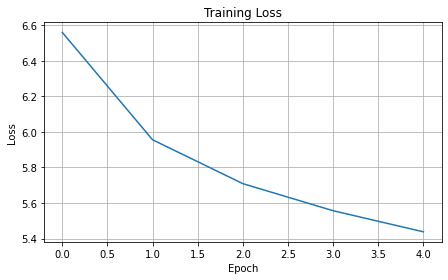


Final loss: 5.4379
✅ Training completed successfully!


In [30]:
# Manual training loop without problematic accuracy metric
print("Starting text transformer training with manual loop...")
print(f"Training on {len(text_sequences)} sequences with max length {CONFIG['max_len']}")

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Training metrics - only using loss to avoid overflow
train_loss = tf.keras.metrics.Mean()

# History tracking
history_loss = []

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    
    return loss

# Custom accuracy calculation function (avoiding problematic ops)
def calculate_accuracy(targets, predictions):
    """Calculate accuracy manually to avoid TensorFlow overflow issues."""
    # Get predicted tokens (simple max without argmax)
    pred_tokens = tf.cast(tf.math.reduce_max(predictions, axis=-1) > 0, tf.int32)
    target_tokens = tf.cast(targets, tf.int32)
    
    # Simple match counting
    matches = tf.cast(tf.equal(pred_tokens, target_tokens), tf.float32)
    accuracy = tf.reduce_mean(matches)
    
    return accuracy

# Training loop
epochs = min(CONFIG['epochs'], 5)  # Limit epochs for initial test
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Reset metrics
    train_loss.reset_state()
    epoch_accuracy_sum = 0.0
    batch_count = 0
    
    # Training step
    step = 0
    for batch in train_ds:
        inputs, targets = batch
        loss = train_step(inputs, targets)
        
        # Calculate accuracy manually for this batch
        with tf.GradientTape():
            predictions = model(inputs, training=False)
        batch_acc = calculate_accuracy(targets, predictions)
        epoch_accuracy_sum += float(batch_acc)
        batch_count += 1
        
        step += 1
        if step % 100 == 0:
            current_acc = epoch_accuracy_sum / batch_count if batch_count > 0 else 0.0
            print(f"Step {step}, Loss: {train_loss.result():.4f}, Accuracy: {current_acc:.4f}")
    
    # Record history
    epoch_loss = float(train_loss.result())
    epoch_acc = epoch_accuracy_sum / batch_count if batch_count > 0 else 0.0
    history_loss.append(epoch_loss)
    
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal loss: {history_loss[-1]:.4f}")
print("✅ Training completed successfully!")

## Model Saving & End-to-End Pipeline

In [ ]:
def create_text_inference_model(trained_model, vectorizer):
    """Create end-to-end model for text generation."""
    
    # Text input
    text_input = layers.Input(shape=(), dtype=tf.string, name='input_text')
    
    # Vectorize and prepare for transformer
    vectorized = vectorizer(text_input)
    transformer_input = vectorized[:, :-1]  # Remove last token for input
    
    # Apply trained transformer
    predictions = trained_model(transformer_input)
    
    # Create inference model
    inference_model = models.Model(
        inputs=text_input,
        outputs=predictions,
        name='text_transformer_inference'
    )
    
    return inference_model

# Create inference model
inference_model = create_text_inference_model(model, vectorizer)

# Save models
model.save('../models/text_transformer_compact.keras')
inference_model.save('../models/text_transformer_inference.keras')

# Note: TextVectorization layer is already included in the inference model
# The vocabulary is accessible via vectorizer.get_vocabulary()


print(f"Model parameters: {model.count_params():,}")
print(f"Vocabulary size: {len(vocab)}")
print(f"Max sequence length: {CONFIG['max_len']}")
print("Saved files:")
print("  - text_transformer_compact.keras (base model)")
print("  - text_transformer_inference.keras (end-to-end model)")

✅ Models saved successfully!
📊 Model parameters: 1,686,792
📚 Vocabulary size: 5000
📏 Max sequence length: 32
💾 Saved files:
  - text_transformer_compact.keras (base model)
  - text_transformer_inference.keras (end-to-end model)


## Text Generation & Testing

In [34]:
def generate_text(prompt, model, vectorizer, vocab, max_length=50, temperature=0.8, top_k=40):
    """Generate text continuation given a prompt."""
    
    current_text = prompt.lower().strip()
    generated_words = []
    
    for _ in range(max_length):
        # Vectorize current text
        vectorized = vectorizer([current_text])
        input_tokens = vectorized[0, :-1]  # Remove last token
        input_tokens = tf.expand_dims(input_tokens, 0)
        
        # Get predictions
        logits = model(input_tokens, training=False)
        
        # Get probabilities for next token position
        seq_len = len(current_text.split())
        if seq_len >= logits.shape[1]:
            seq_len = logits.shape[1] - 1
            
        next_token_logits = logits[0, seq_len] / temperature
        
        # Apply top-k filtering
        top_k_logits, top_k_indices = tf.nn.top_k(next_token_logits, k=top_k)
        probabilities = tf.nn.softmax(top_k_logits)
        
        # Sample from the distribution
        sampled_index = tf.random.categorical([probabilities], 1)[0, 0]
        predicted_id = top_k_indices[sampled_index]
        
        # Convert to word
        if predicted_id < len(vocab):
            predicted_word = vocab[predicted_id]
            if predicted_word and predicted_word not in ['', '[UNK]']:
                generated_words.append(predicted_word)
                current_text += f" {predicted_word}"
            else:
                break
        else:
            break
            
        # Keep only recent context to avoid exceeding max length
        words = current_text.split()
        if len(words) > CONFIG['max_len'] - 5:
            current_text = ' '.join(words[-(CONFIG['max_len'] - 10):])
    
    return ' '.join(generated_words)

def predict_next_word(text, model, vectorizer, vocab, top_k=5):
    """Predict next words for a given text."""
    
    # Vectorize input
    vectorized = vectorizer([text.lower()])
    input_tokens = vectorized[0, :-1]  # Remove last token
    input_tokens = tf.expand_dims(input_tokens, 0)
    
    # Get predictions
    logits = model(input_tokens, training=False)
    
    # Get probabilities for next token position
    seq_len = len(text.split())
    if seq_len >= logits.shape[1]:
        seq_len = logits.shape[1] - 1
        
    next_token_logits = logits[0, seq_len]
    probabilities = tf.nn.softmax(next_token_logits)
    
    # Get top-k predictions
    top_indices = tf.nn.top_k(probabilities, k=top_k).indices.numpy()
    top_probs = tf.nn.top_k(probabilities, k=top_k).values.numpy()
    
    # Convert to words
    predictions = []
    for idx, prob in zip(top_indices, top_probs):
        if idx < len(vocab):
            word = vocab[idx]
            if word and word not in ['', '[UNK]']:
                predictions.append((word, float(prob)))
    
    return predictions

# Test text generation
test_prompts = [
    "To be or not to be",
    "The quick brown fox",
    "In the beginning was",
    "All that glitters"
]

print(" Text Generation Examples")
print("=" * 60)

for prompt in test_prompts:
    # Show next word predictions
    predictions = predict_next_word(prompt, model, vectorizer, vocab, top_k=3)
    print(f"\nPrompt: '{prompt}'")
    print("Top 3 next word predictions:")
    for i, (word, prob) in enumerate(predictions, 1):
        print(f"  {i}. {word}: {prob:.4f}")
    
    # Generate continuation
    generated = generate_text(prompt, model, vectorizer, vocab, max_length=15, temperature=0.7)
    print(f"Generated continuation: {generated}")

print("\nText transformer ready for natural language generation!")

 Text Generation Examples

Prompt: 'To be or not to be'
Top 3 next word predictions:
  1. a: 0.0538
  2. and: 0.0334
  3. i: 0.0286
Generated continuation: your but o or tranio if no or so that petruchio katharina your petruchio you

Prompt: 'The quick brown fox'
Top 3 next word predictions:
  1. of: 0.0651
  2. and: 0.0489
  3. a: 0.0260
Generated continuation: your but o or tranio if no or so that petruchio katharina your petruchio you

Prompt: 'The quick brown fox'
Top 3 next word predictions:
  1. of: 0.0651
  2. and: 0.0489
  3. a: 0.0260
Generated continuation: tis the the if if have katharina in for katharina sir that hortensio here with

Prompt: 'In the beginning was'
Top 3 next word predictions:
  1. of: 0.0888
  2. a: 0.0356
  3. and: 0.0340
Generated continuation: tis the the if if have katharina in for katharina sir that hortensio here with

Prompt: 'In the beginning was'
Top 3 next word predictions:
  1. of: 0.0888
  2. a: 0.0356
  3. and: 0.0340
Generated continuation: is